<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/base_llm_emergent_capability.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Emergent Capability Analysis

This notebook shows how to apply observational scaling laws to predict the "emergent" capabilities, corresponding to the Sec 4.1 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [ ]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()

Load emergent capability eval results for base LLMs

In [4]:
eval_result_path = "./eval_results/base_llm_emergent_capability_eval.csv"
emerg_cap_eval = pd.read_csv(eval_result_path)

Merge eval results

In [5]:
base_llm_eval_with_emg_eval = pd.merge(base_llm_benchmark_eval, emerg_cap_eval, on='Model')

## Scaling Analysis

Specify downstream metrics for analysis

In [6]:
# Arithmetic tasks
EMERG_CAP_ARITHMETIC_TASK_MAP = {
    'arithmetic_3ds_2_acc': "3-Digit Substraction",
    'arithmetic_2dm_2_acc': "2-Digit Multiplication",
    ## additional tasks
    # 'arithmetic_3da_2_acc': "3-Digit Addiiton",
    # 'arithmetic_2da_2_acc': "2-Digit Addiiton",
}

EMERG_CAP_ARITHMETIC_TASKS = list(EMERG_CAP_ARITHMETIC_TASK_MAP.keys())

# Nonarithmetic tasks
EMERG_CAP_NONARITHMETIC_TASK_MAP = {
    'word_unscrambling_2_exact_match': "Word Unscramble",
    'parsinlu_qa_2_acc': "Persian QA",
    ## additional tasks
    # 'ipa_transliterate_2_bleu': "IPA transliterate",
}

EMERG_CAP_NONARITHMETIC_TASKS = list(EMERG_CAP_NONARITHMETIC_TASK_MAP.keys())

EMERG_CAP_TASK_MAP = {**EMERG_CAP_ARITHMETIC_TASK_MAP, **EMERG_CAP_NONARITHMETIC_TASK_MAP}
EMERG_CAP_TASKS = EMERG_CAP_NONARITHMETIC_TASKS + EMERG_CAP_ARITHMETIC_TASKS

Setup specific arguments

In [7]:
EMERG_CAP_DEFAULT_SETUP_KWARGS = {
    # Metric normalization
    "y_metric_process_funcs": "minmax_norm",

    # Group markers by model family
    "df_groupby": 'Model Family',  
    
    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},   # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

In [8]:
EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS = {}    

for e in EMERG_CAP_TASKS:
    EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e] = {}

    # Metric range
    ## Minimum: the metric value of random guess
    if 'parsinlu_qa' in e:
        random_val = 0.25
    else:
        random_val = 0.0

    ## Maximum: the metric value of perfect prediction
    if "bleu" in e:
        max_val = 100.0
    else:
        max_val = 1.0
    
    EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e]['y_metric_range'] = (random_val, max_val)

    # PCA & cutoff arguments
    if 'arithmetic' in e:  # Arithmetic tasks
        # Exclude the GSM8K metrics to avoid making the prediction task trivial
        EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e].update(NONGSM_PCA_PREPROCESS_KWARGS)
        # Set a lower cutoff threshold to make the task more challenging
        EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e].update({
            "split_method": "cutoff_by_FLOPs (1E21)",
            "cutoff_threshold": 22,
            "plot_adjust_kwargs": {"ylim": [-0.03, 1.13]}
        })
    else:  # Nonarithmetic tasks, use default setup
        EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e].update(DEFAULT_PCA_PREPROCESS_KWARGS)
        EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS[e].update({
            "split_method": "cutoff_by_FLOPs (1E21)",
            "cutoff_threshold": 84,
        })
    

In [9]:
PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]

#### Scaling Predictions

Compare the scaling predictions with observation scaling laws (PCs) and with compute scaling laws (model size or training FLOPs)

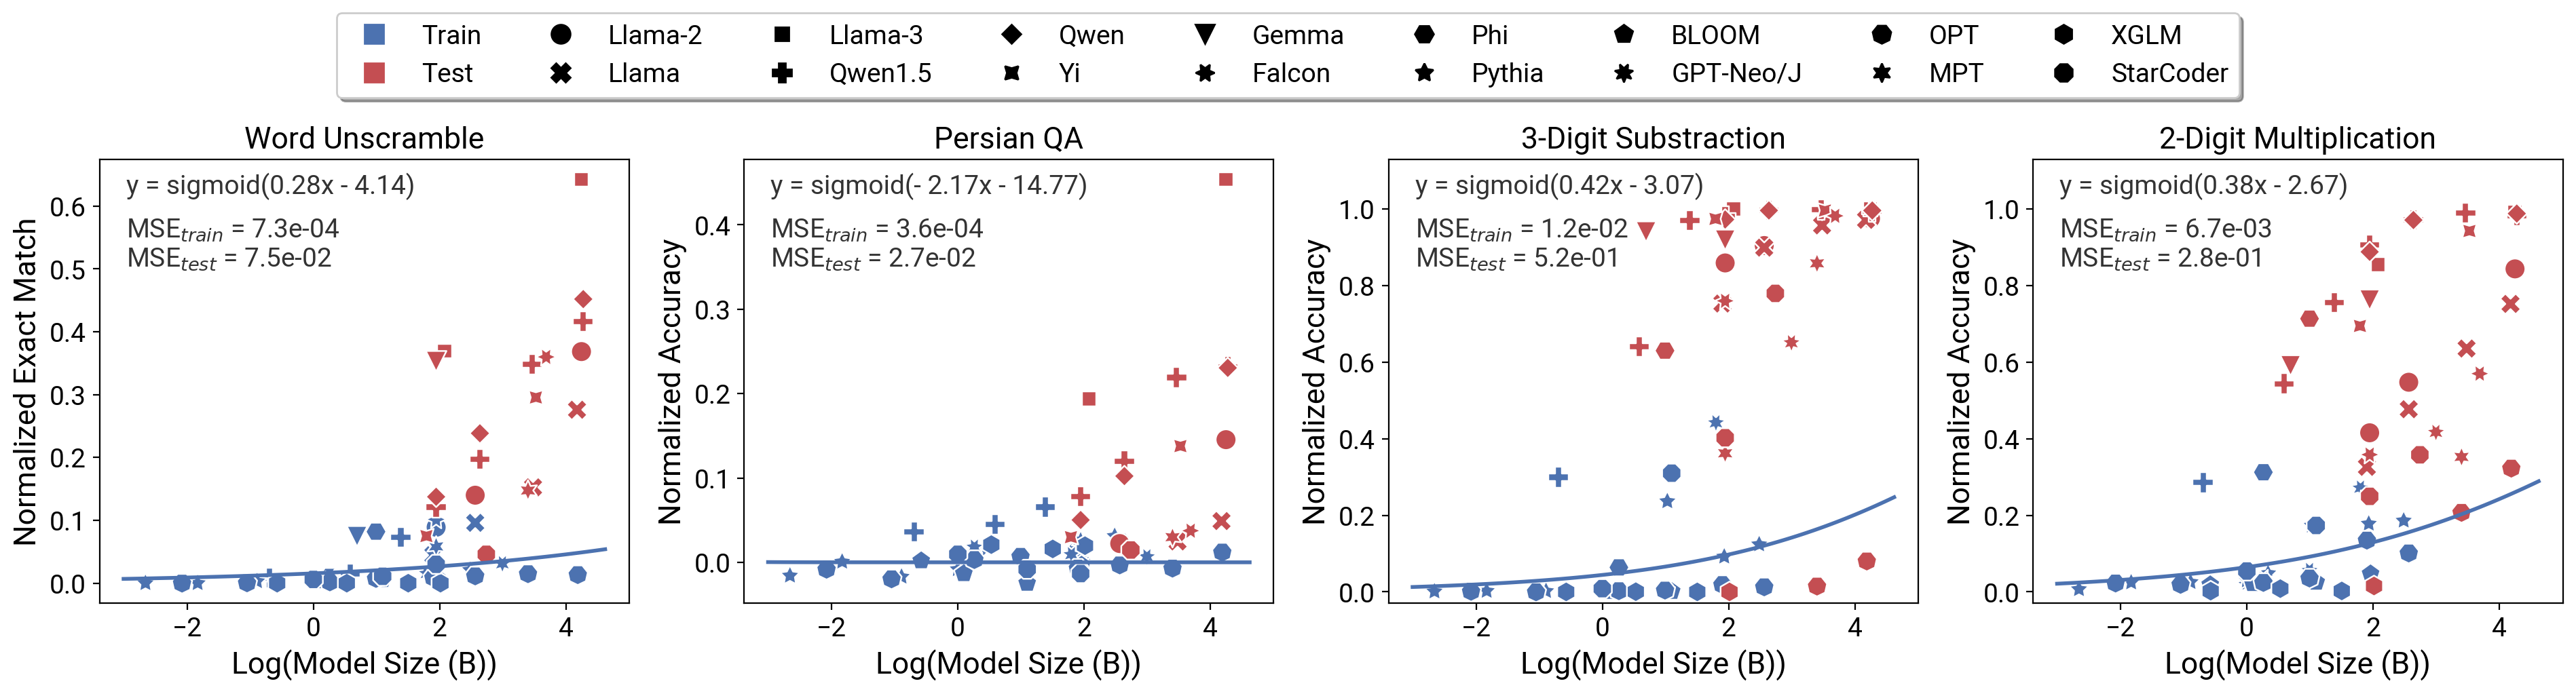

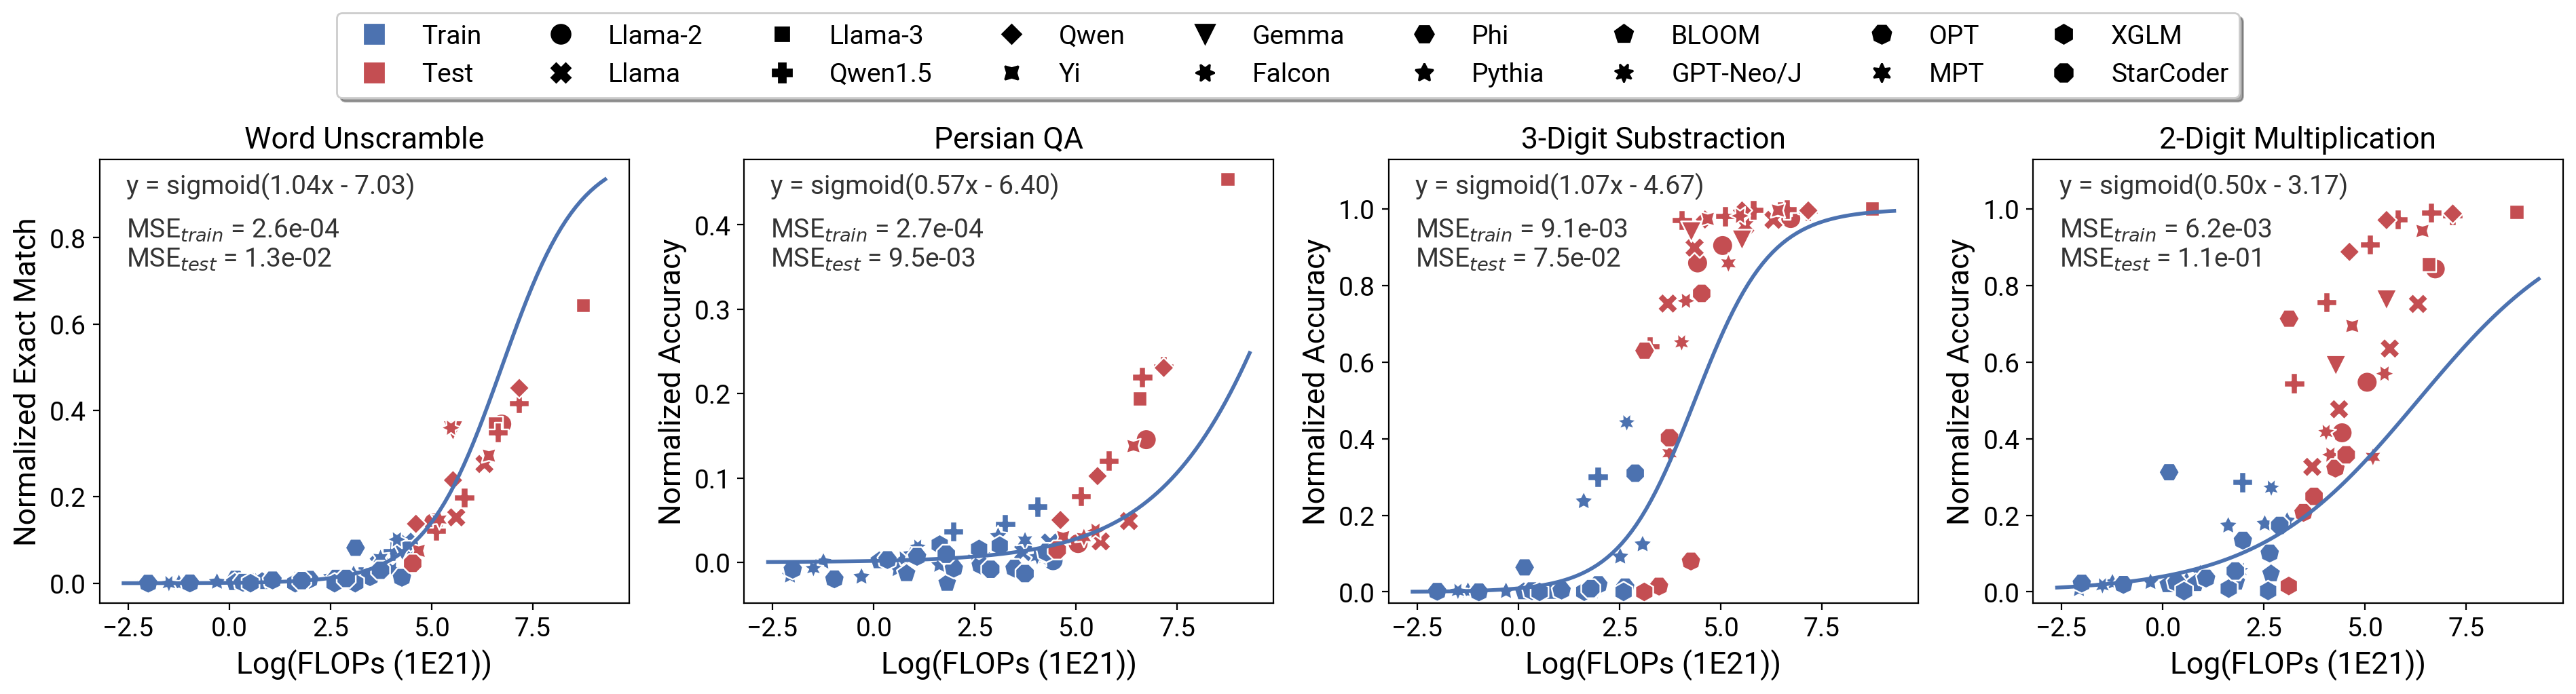

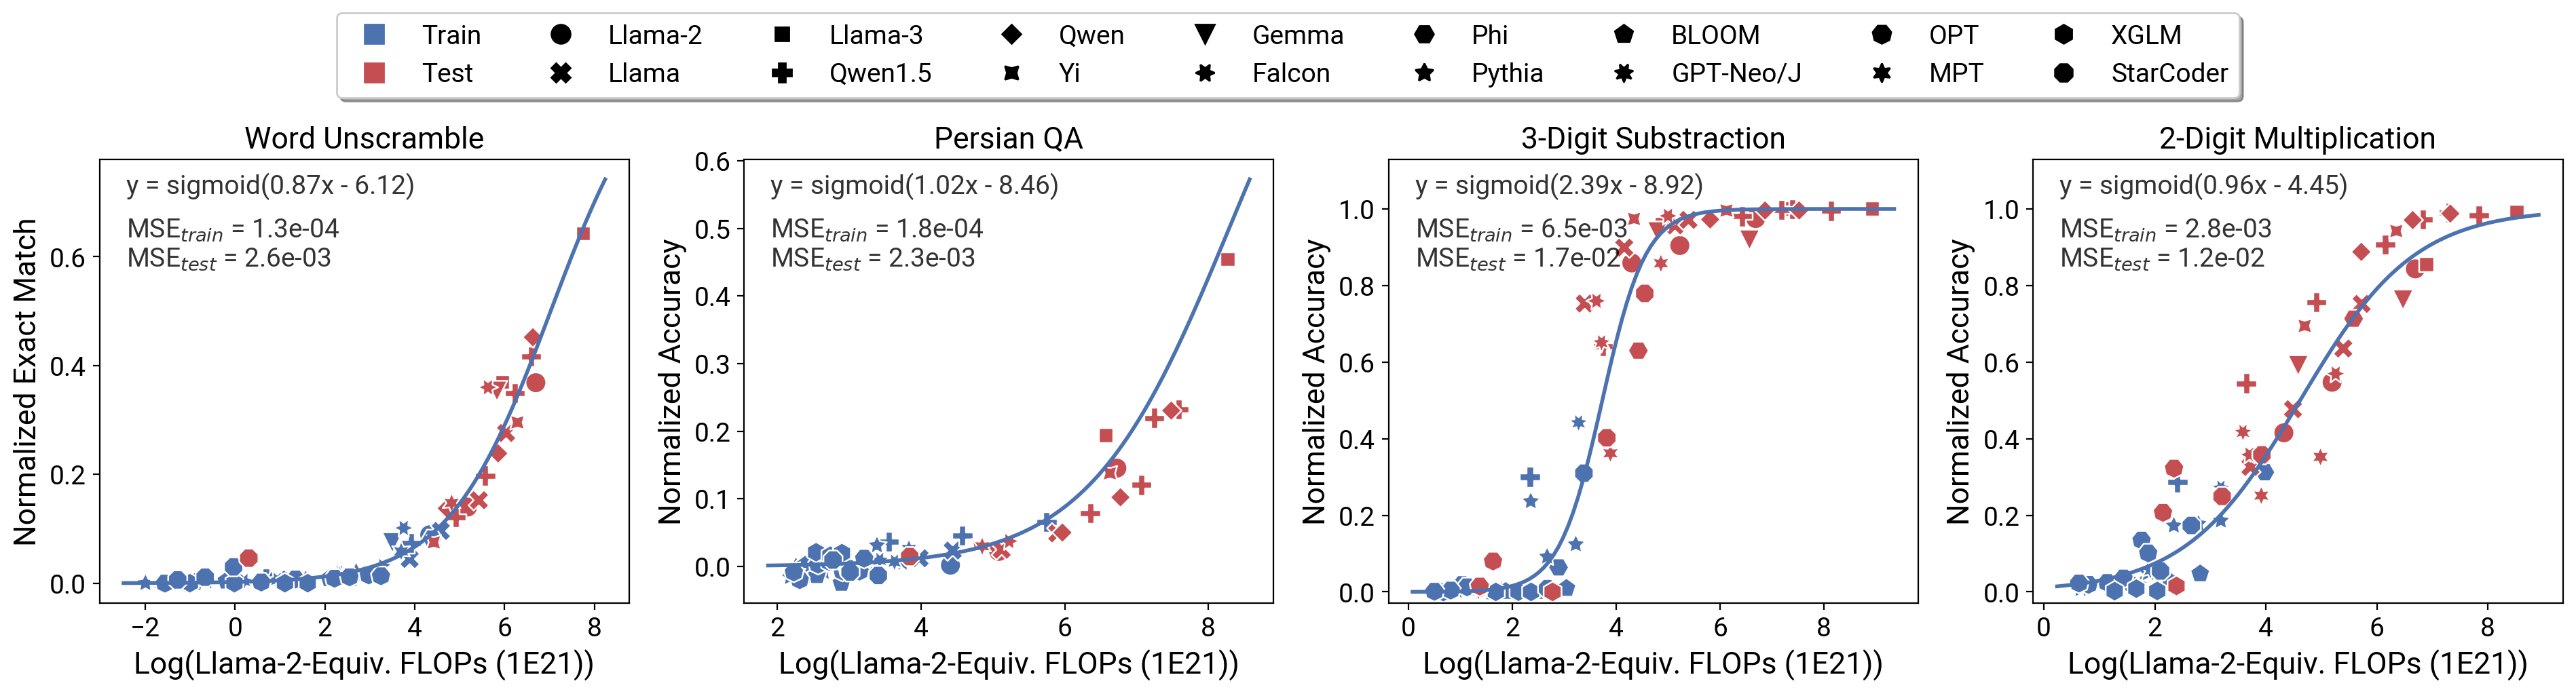

In [10]:
for x_metrics in PLOT_X_METRICS_LIST:       
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_emg_eval, EMERG_CAP_TASKS, [x_metrics], 
        EMERG_CAP_DEFAULT_SETUP_KWARGS, y_metric_specific_kwargs=EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS, 
        filter_model_family=EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES, ymetric2title_map=EMERG_CAP_TASK_MAP,
        plot_legend=True, legend_nrow=2,
    )
    

#### Robustness Analysis

The effect of PCs: compare the scaling predictions using different number of PCs and with training FLOPs as baseline

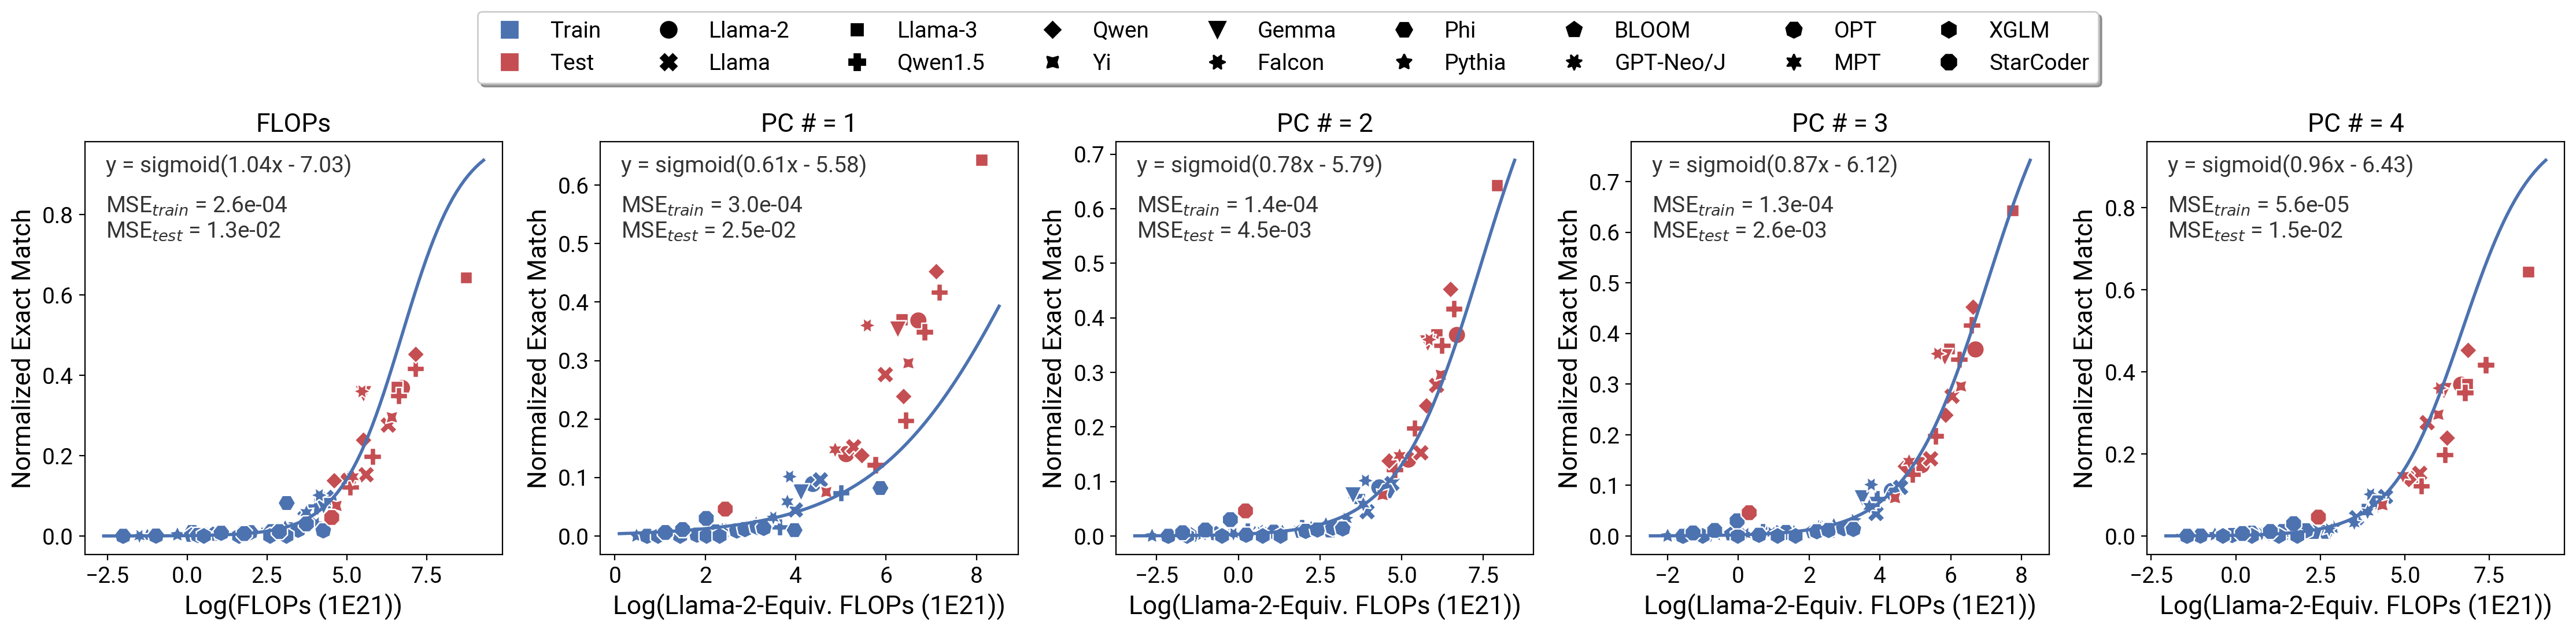

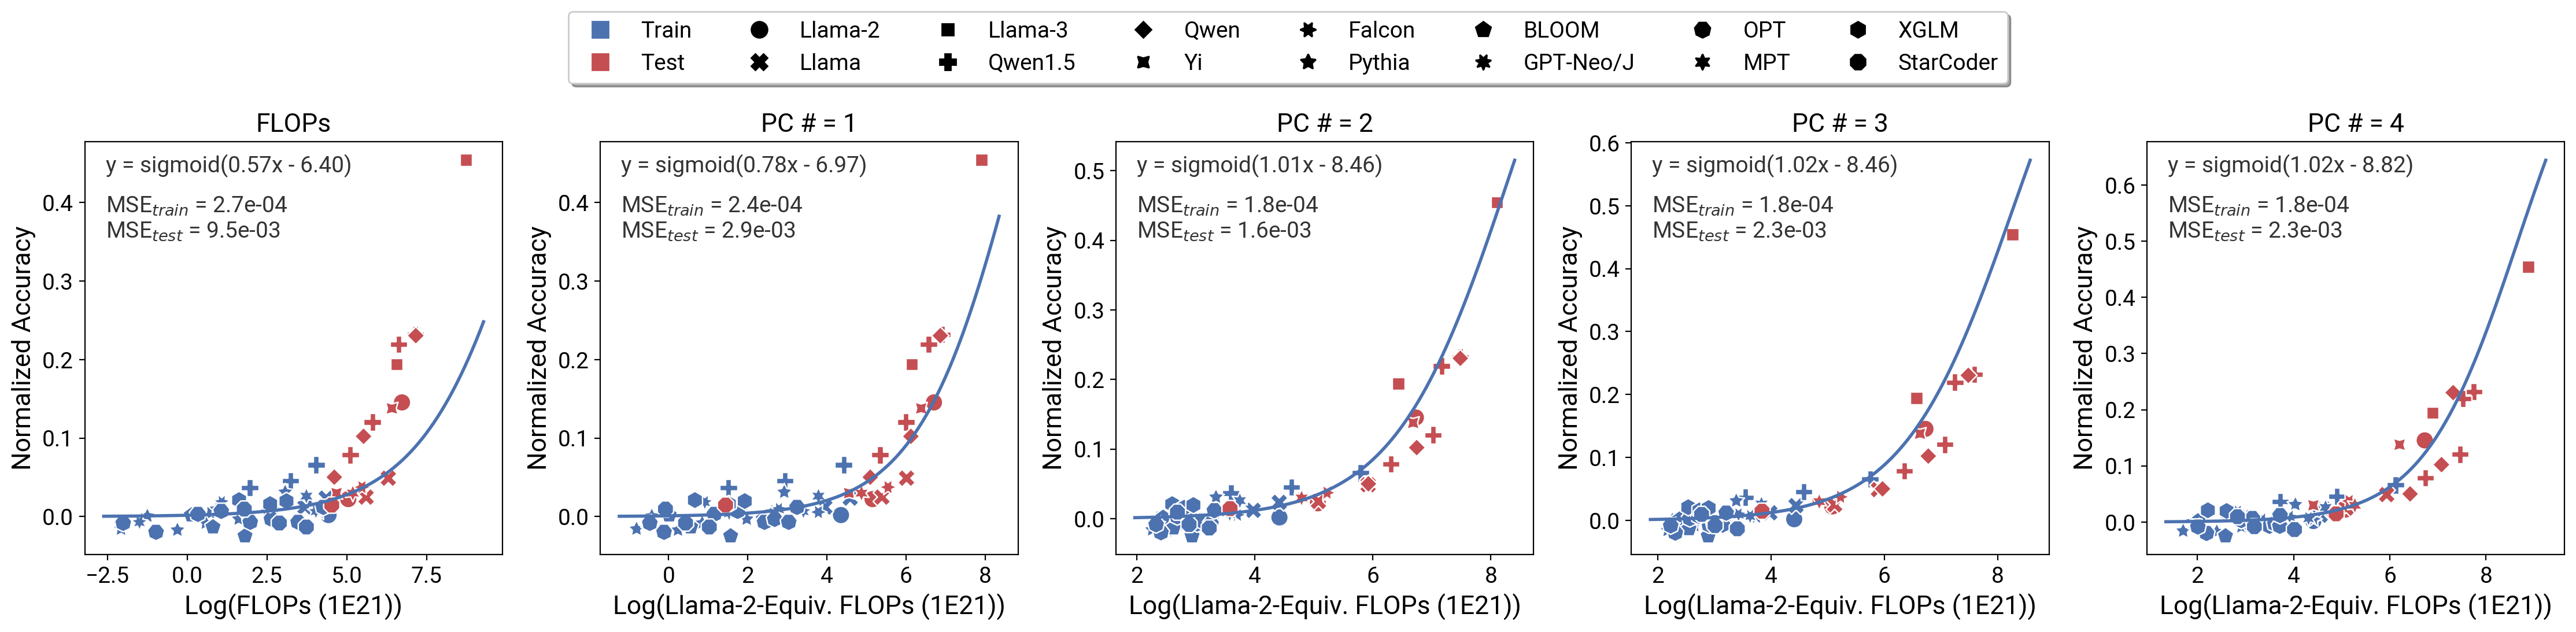

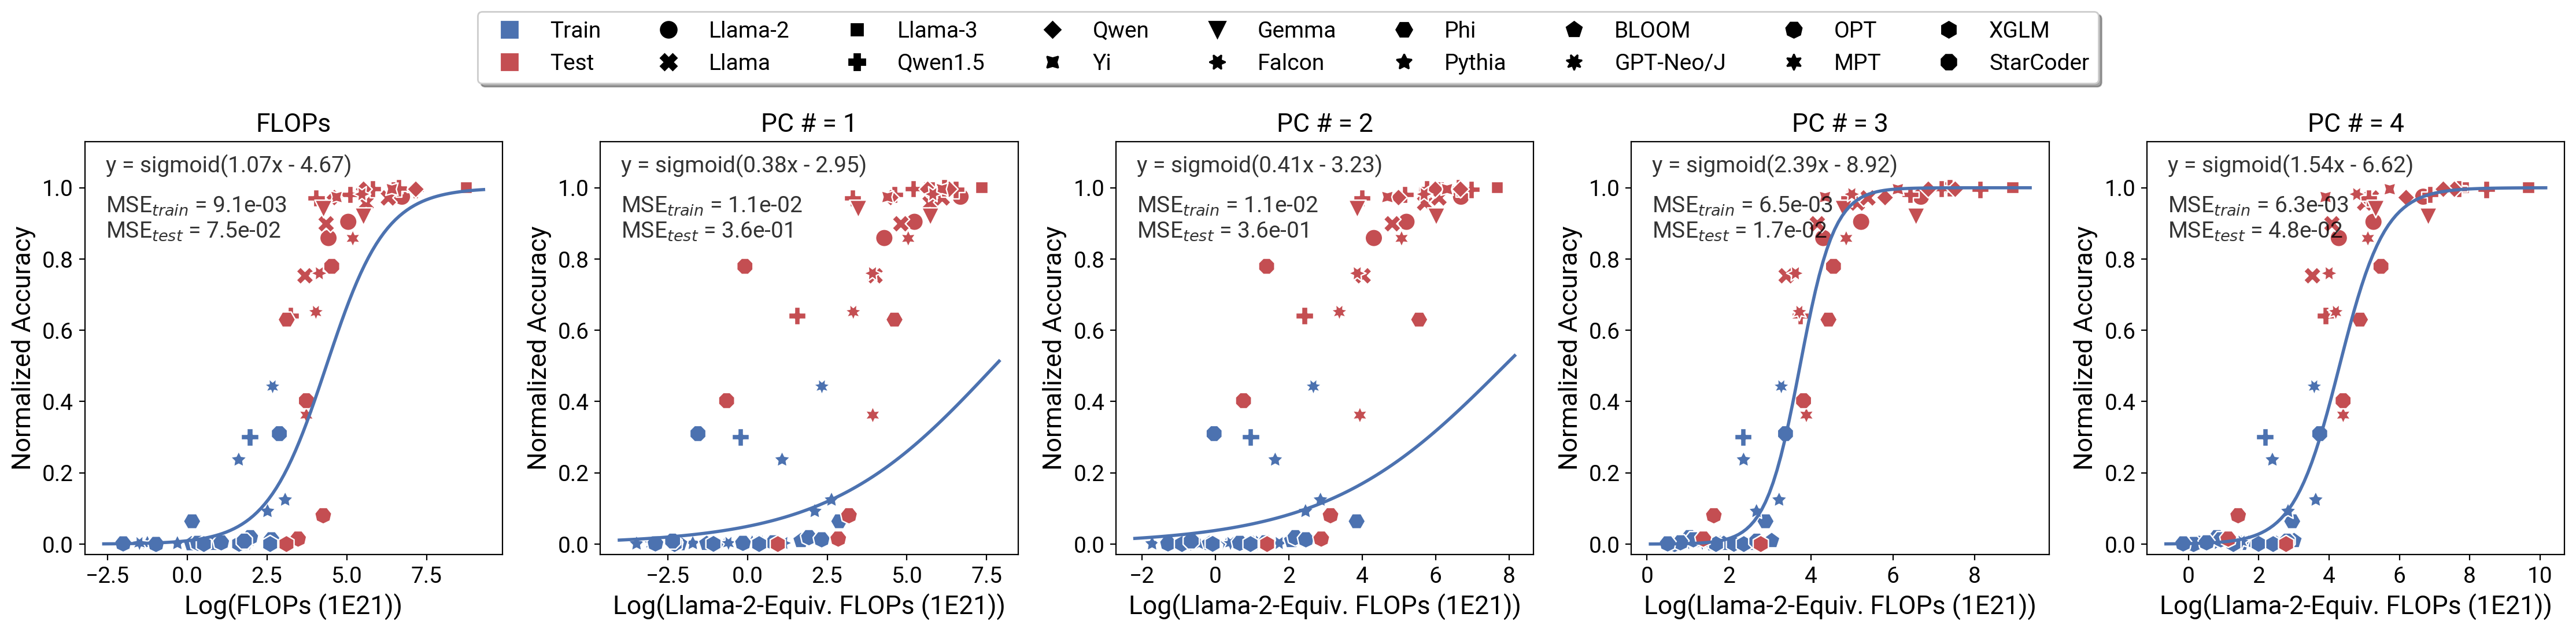

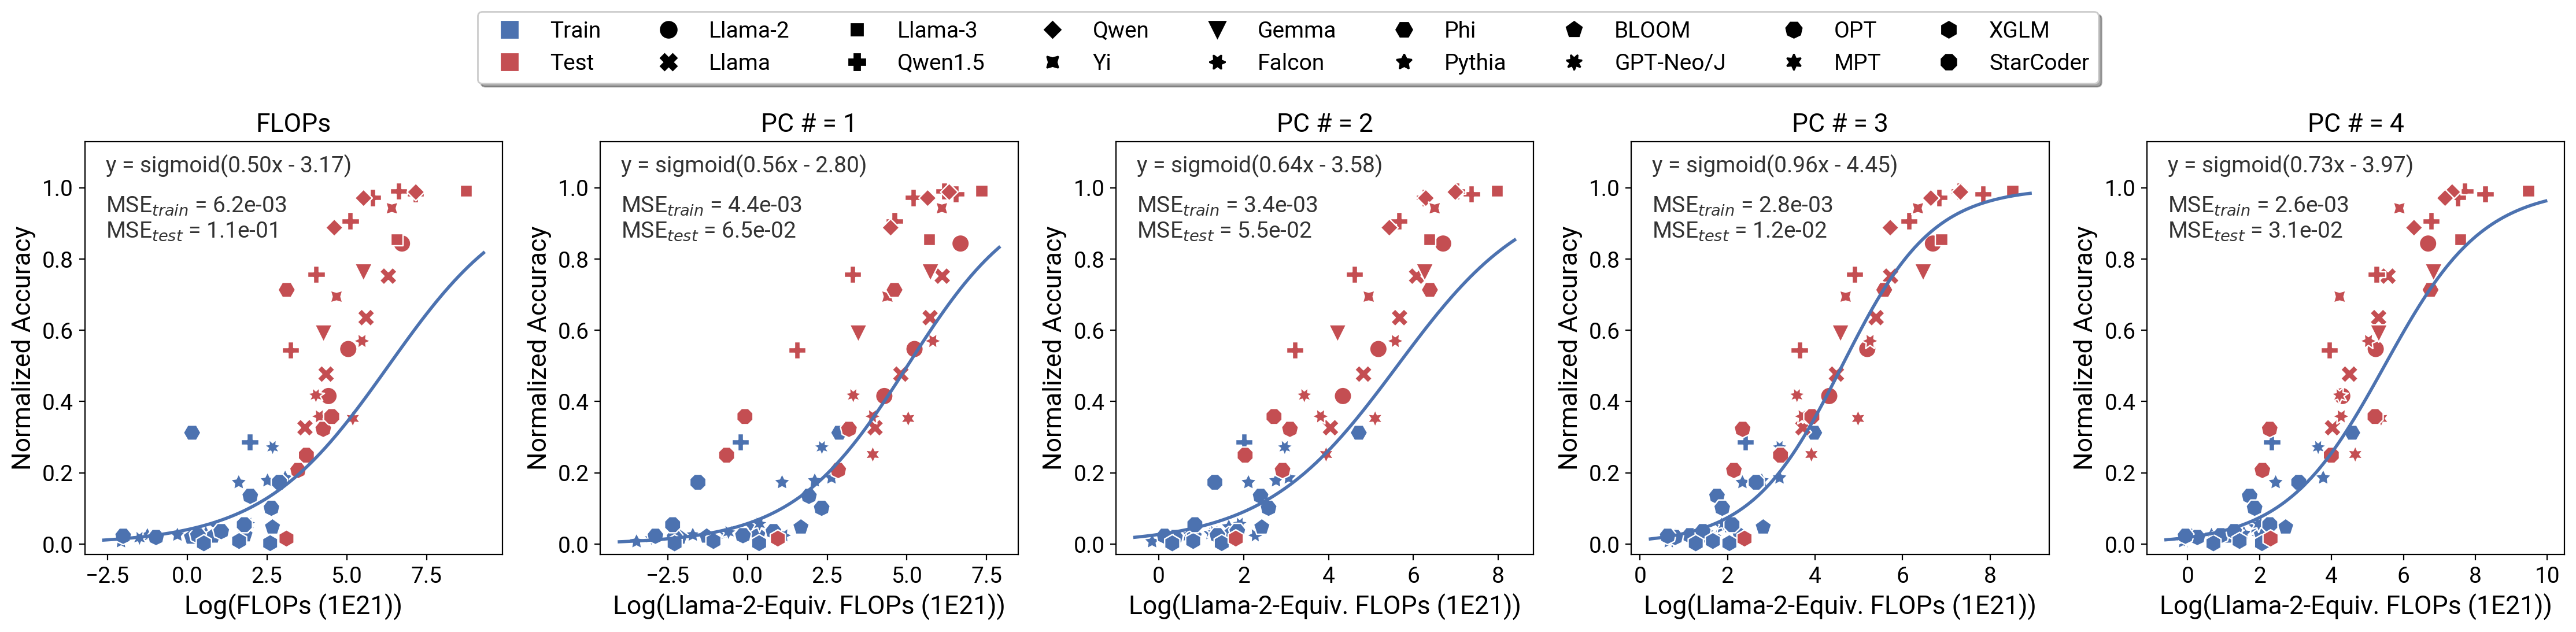

In [11]:
DIFF_PC_NUM_PLOT_X_METRICS_LIST = [TRAINING_FLOPS_METRIC, PC_METRIC_NUM_1, PC_METRIC_NUM_2, PC_METRIC_NUM_3, PC_METRIC_NUM_4]

for y_metric in EMERG_CAP_TASKS:
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_emg_eval, [y_metric], DIFF_PC_NUM_PLOT_X_METRICS_LIST, 
        EMERG_CAP_DEFAULT_SETUP_KWARGS, y_metric_specific_kwargs=EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS, 
        filter_model_family=EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES, ymetric2title_map=EMERG_CAP_TASK_MAP,
        plot_legend=True, legend_nrow=2, transpose=True
    )

The effect of cutoff: vary the metric cutoff, plot the test MSE, and compute the mean test MSE (area under the error curve)

4it [07:45, 116.29s/it]


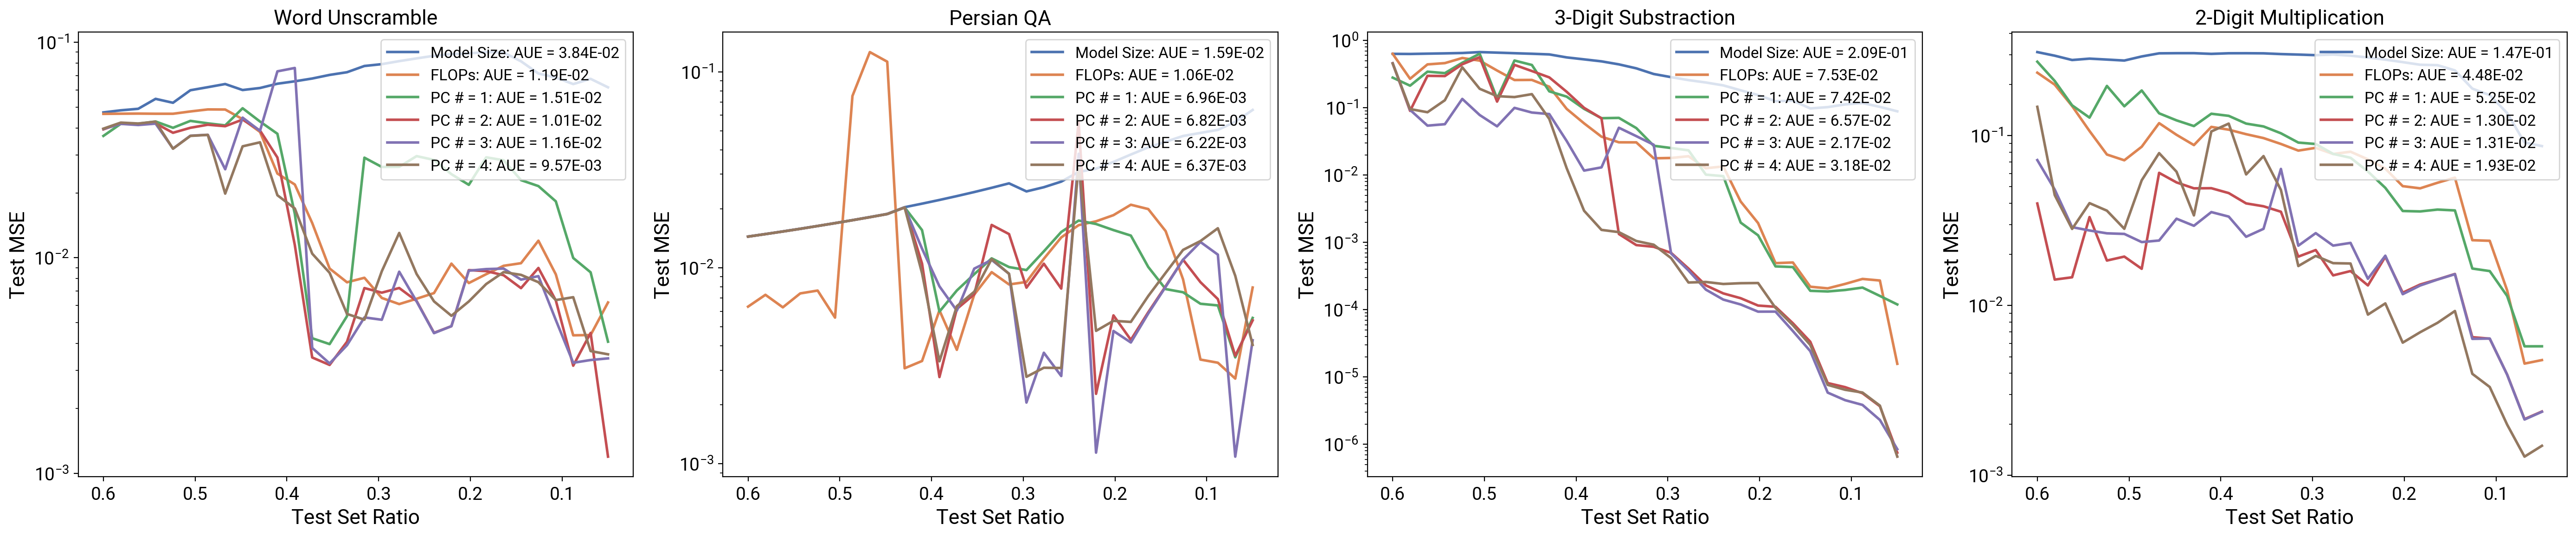

In [12]:
# vary the Y metric (downstream performance) cutoff to change test size from 0.6 to 0.05, simulating a weak to strong generalization setup
split_limit_ranges = np.linspace(0.6, 0.05, 30)
rank_metric_name = "y_metric"

regress_metrics_to_plot = ['mse_test']

# remove default cutoff setup args
setup_specific_kwargs = copy.deepcopy(EMERG_CAP_EVAL_SETUP_SPECIFIC_KWARGS)
for e, kwargs in setup_specific_kwargs.items():
    del kwargs["split_method"]
    del kwargs["cutoff_threshold"]


fig = plot_reg_metric_curves(
    base_llm_eval_with_emg_eval,
    ALL_X_METRICS_LIST,
    EMERG_CAP_TASKS,
    rank_metric_name,
    split_limit_ranges,
    regress_metrics_to_plot,
    EMERG_CAP_DEFAULT_SETUP_KWARGS,
    filter_model_family=EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES,
    y_metric_specific_kwargs=setup_specific_kwargs,
    ymetric2title_map=EMERG_CAP_TASK_MAP,
)